# test svm fillip

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from preprocessing import generate_balanced_data, hog_features, color_cutoff
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
from time import time
import random

In [2]:
seed = 1
np.random.seed(seed)
random.seed(seed)

In [3]:
dataset = np.load('../data/dataset.npz')
X, y = dataset['X'], dataset['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=seed, stratify=y
)

X_train, y_train = generate_balanced_data(X_train, y_train, seed=seed)

In [4]:
# components_range = [0.9, 0.92, 0.94, 0.95, 0.99, 0.999, 0.9999]
# for n in components_range:
#     pca = PCA(n_components=n)
#     X_train_pca = pca.fit_transform(X_train)
#     svc = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
#     scores = cross_val_score(svc, X_train_pca, y_train, cv=3)
    # print(f"n_components: {n}, Cross-validation accuracy: {np.mean(scores):.2f}")

without pca

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END C=40.64809212974488, coef0=0.7473906727826023, degree=3, gamma=0.09588427629700286, kernel=poly, shrinking=False; total time=  16.3s
[CV] END C=40.64809212974488, coef0=0.7473906727826023, degree=3, gamma=0.09588427629700286, kernel=poly, shrinking=False; total time=  16.1s
[CV] END C=40.64809212974488, coef0=0.7473906727826023, degree=3, gamma=0.09588427629700286, kernel=poly, shrinking=False; total time=  16.1s
[CV] END C=40.64809212974488, coef0=0.7473906727826023, degree=3, gamma=0.09588427629700286, kernel=poly, shrinking=False; total time=  15.8s
[CV] END C=40.64809212974488, coef0=0.7473906727826023, degree=3, gamma=0.09588427629700286, kernel=poly, shrinking=False; total time=  15.1s
[CV] END C=88.69910899335613, coef0=0.09902479244233042, degree=4, gamma=0.09290834723332915, kernel=poly, shrinking=True; total time=  18.2s
[CV] END C=88.69910899335613, coef0=0.09902479244233042, degree=4, gamma=0.0929083472333

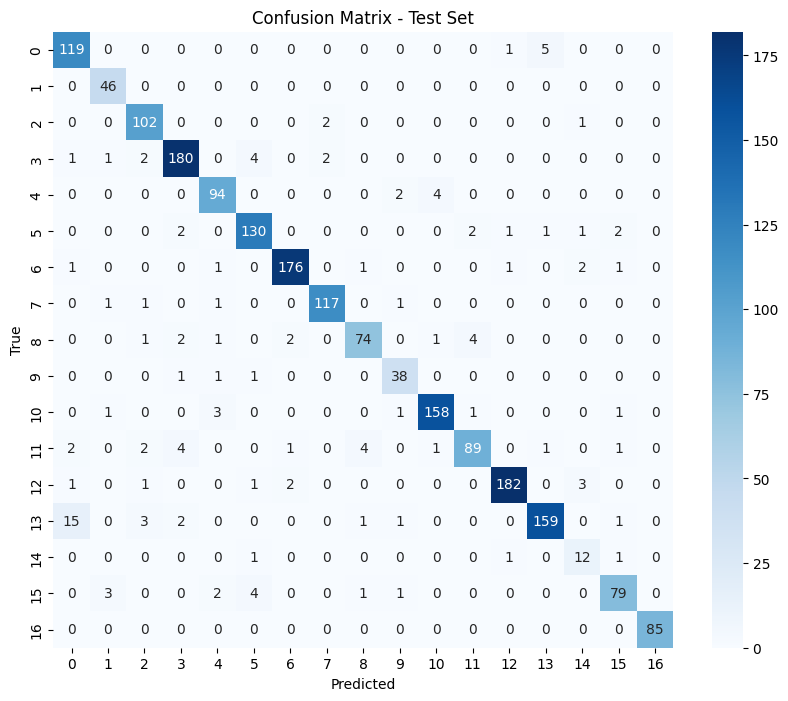

In [5]:
# using a simpler color cutoff
X_train_cutoff = color_cutoff(X_train, black_cutoff=90, white_cutoff=230)
X_test_cutoff = color_cutoff(X_test, black_cutoff=90, white_cutoff=230)

# built in 0-1 scaler
scaler = MinMaxScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_cutoff)
X_test_hog_scaled = scaler.transform(X_test_cutoff)

uniform_samples = 100
param_dist = {
    'C': np.random.uniform(0.1, 100, size=uniform_samples),
    'gamma': np.random.uniform(1e-4, 1e-1, size=uniform_samples),
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': np.random.uniform(0, 1, size=uniform_samples),
    'shrinking': [True, False],
}

svc = SVC(random_state=seed, probability=True)
random_search = RandomizedSearchCV(
    svc, param_distributions=param_dist, n_iter=5,
    cv=5, n_jobs=1, verbose=2, random_state=seed, scoring='accuracy'
)
time_start = time()
random_search.fit(X_train_hog_scaled, y_train)
print(f"Random Search took {time() - time_start:.2f} seconds")
print(f"Best Parameters: {random_search.best_params_}")

best_svc = random_search.best_estimator_

y_test_pred = best_svc.predict(X_test_hog_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

with pca

Data went from (12920, 400) to (12920, 85)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END C=39.9470619254182, coef0=0.44409787814824164, degree=3, gamma=0.051398707484509115, kernel=poly, shrinking=False; total time=   7.1s
[CV] END C=39.9470619254182, coef0=0.44409787814824164, degree=3, gamma=0.051398707484509115, kernel=poly, shrinking=False; total time=   7.0s
[CV] END C=39.9470619254182, coef0=0.44409787814824164, degree=3, gamma=0.051398707484509115, kernel=poly, shrinking=False; total time=   7.1s
[CV] END C=39.9470619254182, coef0=0.44409787814824164, degree=3, gamma=0.051398707484509115, kernel=poly, shrinking=False; total time=   7.0s
[CV] END C=39.9470619254182, coef0=0.44409787814824164, degree=3, gamma=0.051398707484509115, kernel=poly, shrinking=False; total time=   6.7s
[CV] END C=62.4689508824527, coef0=0.5442995161536633, degree=4, gamma=0.08311699826341318, kernel=poly, shrinking=True; total time=  11.0s
[CV] END C=62.4689508824527, coef0=0.54429

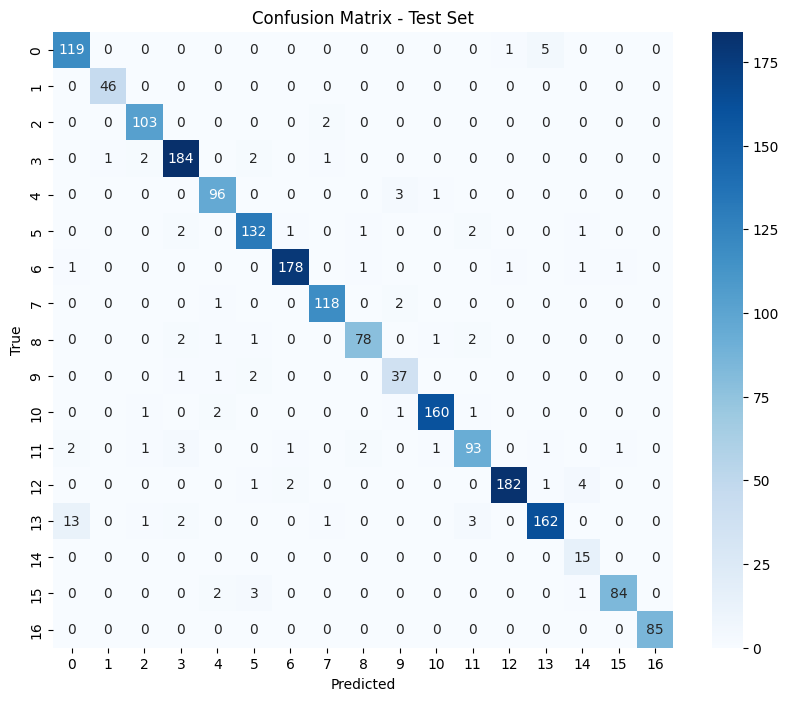

In [27]:
# using a simpler color cutoff
X_train_cutoff = color_cutoff(X_train, black_cutoff=90, white_cutoff=230)
X_test_cutoff = color_cutoff(X_test, black_cutoff=90, white_cutoff=230)

# built in 0-1 scaler
scaler = MinMaxScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_cutoff)
X_test_hog_scaled = scaler.transform(X_test_cutoff)

# decompose the data while keeping 95% of the variance
pca = PCA(n_components=0.95, random_state=seed)
X_train_pca = pca.fit_transform(X_train_hog_scaled)
X_test_pca = pca.transform(X_test_hog_scaled)

print(f"Data went from {X_train_hog_scaled.shape} to {X_train_pca.shape}")

uniform_samples = 100
param_dist = {
    'C': np.random.uniform(0.1, 100, size=uniform_samples),
    'gamma': np.random.uniform(1e-4, 1e-1, size=uniform_samples),
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': np.random.uniform(0, 1, size=uniform_samples),
    'shrinking': [True, False],
}

svc = SVC(random_state=seed, probability=True)
random_search = RandomizedSearchCV(
    svc, param_distributions=param_dist, n_iter=5,
    cv=5, n_jobs=1, verbose=2, random_state=seed, scoring='accuracy'
)
time_start = time()
random_search.fit(X_train_pca, y_train)
print(f"Random Search took {time() - time_start:.2f} seconds")
print(f"Best Parameters: {random_search.best_params_}")

best_svc = random_search.best_estimator_

y_test_pred = best_svc.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


#### OOD Images

In [44]:
dataset = np.load('../data/corrupt_dataset.npz')
X = dataset['X']

# using a simpler color cutoff
X_cutoff = color_cutoff(X, black_cutoff=90, white_cutoff=230)

# built in 0-1 scaler
X_hog_scaled = scaler.transform(X_cutoff)

X_pca = pca.transform(X_hog_scaled)

y_pred = best_svc.predict_proba(X_pca)


Detected 68 out-of-distribution images out of 935 total images.


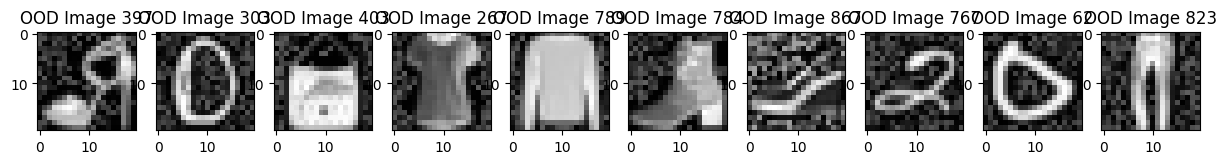

In [45]:
from sklearn.cluster import KMeans

n_clusters = 18
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(y_pred)

corrupt_cluster_labels = kmeans.predict(y_pred)

corrupt_distances = kmeans.transform(y_pred).min(axis=1)

distance_threshold = np.mean(corrupt_distances) + 2 * np.std(corrupt_distances)
ood_indices = np.where(corrupt_distances > distance_threshold)[0]

print(f"Detected {len(ood_indices)} out-of-distribution images out of {len(y_pred)} total images.")

n_samples = min(10, len(ood_indices))
random_indices = np.random.choice(ood_indices, n_samples, replace=False)

fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
for i, idx in enumerate(random_indices):
    axes[i].imshow(X[idx].reshape(20, 20), cmap='gray')
    axes[i].set_title(f'OOD Image {idx}')
plt.show()